# Volatilidad implícita
## Introducción


Pensemos en un activo cualquiera, este activo refleja una varianza histórica que podemos observar y medir.

Este activo puede ser subjacente de distintos tipos de derivados y como bien sabemos esto significa que el precio de estos dependerá de las distintas caracteristicas de nuestro subjacente.

In [67]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

In [21]:

ticker = yf.Ticker('AAPL')
prices = ticker.history(period="2y")['Close']
calls = ticker.option_chain(ticker.options[0]).calls


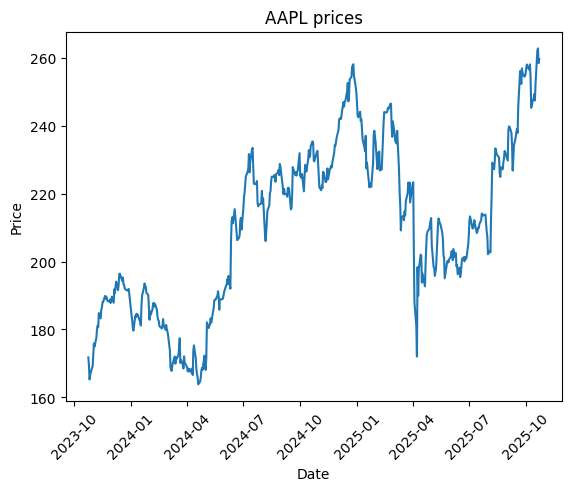

In [29]:
plt.plot(prices)
plt.title(f"{ticker.ticker} prices")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [32]:
current_price = prices.iloc[-1]
print("current price:",current_price)

current price: 259.5799865722656


Viendo el precio actual del activo y el histórico haga una estimacion vaga del precio de las siguientes opciones.

In [50]:
k=5
print(f"Expiration date: {ticker.options[0]}")
mask =(calls['strike']<=(current_price+k)) & (calls['strike']>=(current_price-k))
masked_calls = calls[mask][['contractSymbol','strike']]
masked_calls

Expiration date: 2025-10-24


,contractSymbol,strike
32,AAPL251024C00255000,255.0
33,AAPL251024C00257500,257.5
34,AAPL251024C00260000,260.0
35,AAPL251024C00262500,262.5


Podriamos usar otras herramisntas a nuestra dispocision para tener mas informacion y mejorar nuestra estimacion. Por ejemplo podemos calcular la probabilidad de que se ejecuten.

Si queremos calcular la probabilidad de que se ejecuten tenemos que usar el modelo
$$dS=S_0 \mu dt + S_0 \sigma dW$$

In [63]:
S_0 = current_price
mu = prices.pct_change().mean()
sigma = prices.pct_change().std()
t = (dt.datetime.today()-dt.datetime.strptime(ticker.options[0], "%Y-%m-%d")).days + 1
print(f"S_0: {current_price}")
print(f"mu: {mu}")
print(f"sigma: {sigma}")
print(f"dt: {t}")

S_0: 259.5799865722656
mu: 0.0009797456897589047
sigma: 0.01771680003805864
dt: 1


Sabemos que el valor esperado del cambio en el precio del activo es

$$E[dS]=S_0 \mu dt$$

y la varianza esta dada por

$$Var[dS]= S_0^2 \sigma^2 dt$$


In [66]:
E = S_0*mu*t
Var = S_0**2*sigma**2*t
print(f"E[dS]: {E}")
print(f"Var[dS]: {Var}")

E[dS]: 0.2543223729918516
Var[dS]: 21.15012693898013


Con las siguientes probabilidades, ajusta tus estimaciones de cuanto crees que sea la prima de estas opciones call.

In [73]:
K = masked_calls['strike'].values
masked_calls['execution probability']=1-stats.norm.cdf((K-current_price),E,Var**0.5)
masked_calls

,contractSymbol,strike,execution probability
32,AAPL251024C00255000,255.0,0.853412
33,AAPL251024C00257500,257.5,0.694125
34,AAPL251024C00260000,260.0,0.485630
35,AAPL251024C00262500,262.5,0.281081



### Precio justo de una opción (Black Scholes)

una herramienta mas potente para estimar el precio de las primas puede ser encontrar el precio justo usando black scholes

$$C(S, t) = S \cdot N(d_1) - K e^{-r(T-t)} \cdot N(d_2)$$

$$d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}$$

$$d_2 = d_1 - \sigma\sqrt{T-t}
$$


In [86]:
r = (1+0.071)**(1/255)-1
d1 = (np.log(S_0/K) + (r + sigma**2/2)*t)/(sigma*t**0.5)
d2 = d1 - sigma*t**0.5
C = S_0*stats.norm.cdf(d1) - K*np.exp(-r*t)*stats.norm.cdf(d2)
masked_calls['fair price'] = C
masked_calls

,contractSymbol,strike,execution probability,fair price
32,AAPL251024C00255000,255.0,0.853412,5.014073
33,AAPL251024C00257500,257.5,0.694125,3.099280
34,AAPL251024C00260000,260.0,0.485630,1.666191
35,AAPL251024C00262500,262.5,0.281081,0.759595


Con esta nueva informacion ajusta una ultima vez tus estimaciones de las primas.

Para este punto habran notado que el precio de la prima baja cuando las opciones son mas riesgosas y sube cuando son mas seguras, por lo que haciendo de lado variables que no podemos cambiar como el intervalo de tiempo, el precio del activo o la tasa libre de riesgo, el precio de la prima de una opcion se puede ver como una funcion de la varianza (o volatilidad) del activo.

En el mercado podemos observar las siguientes primas `lastPrice` que son cercanas pero distintas al precio justo que calculamos. Ahora pregúntate:

Qué tan cercana fue tu estimación?
A qué crees que se deba la diferencia entre el precio justo y la prima que vemos en el mercado?



In [88]:
calls[mask]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
32,AAPL251024C00255000,2025-10-23 19:59:09+00:00,255.0,4.89,4.80,5.00,0.44,9.887643,4183,26222,0.351569,True,REGULAR,USD
33,AAPL251024C00257500,2025-10-23 19:59:56+00:00,257.5,2.74,2.72,2.83,0.04,1.481480,18794,10697,0.291999,True,REGULAR,USD
34,AAPL251024C00260000,2025-10-23 19:59:54+00:00,260.0,1.20,1.20,1.24,-0.22,-15.492951,63293,26178,0.265632,False,REGULAR,USD
35,AAPL251024C00262500,2025-10-23 19:59:58+00:00,262.5,0.37,0.36,0.40,-0.34,-47.887320,38889,20189,0.257332,False,REGULAR,USD


La diferencia se debe a que en el mercado los precios de los derivados no son fijos, estan sujetos a movimientos segun su oferta y demanda.

Otra forma de ver esto es que el precio de la prima refleja la expectativa que el mercado tiene de la volatilidad en el periodo de la opcion.

Y si podemos calcular la prima en funcion a la volatilidad (Black Scholes), eso quiere decir que tambien podemos ver la volatilidad en funcion de la prima.

Para hacer esto podemos utilizar BS y metodos numericos:

In [90]:


from scipy.optimize import brentq

K=257.5
def BS(sigma):
  d1=(np.log(S_0/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
  d2=d1-sigma*np.sqrt(t)
  c=S_0*stats.norm.cdf(d1)-K*np.exp(-r*t)*stats.norm.cdf(d2)
  return c

def objective(sigma):
    return BS(sigma) - 2.74

implied_vol = brentq(objective, -0.01, 0.07, xtol=1e-6)
print(f"La volatilidad implícita es: {implied_vol:.6f}  vs {sigma}")



La volatilidad implícita es: 0.013701  vs 0.01771680003805864


## Tarea

Comparar la volatilidad implicita de un grupo de opciones de un activo. con la varianza observada en dicho periodo.

Para lograr esto tenemos que calcular la volatilidad implicita de las opciones hoy, guardar esta informacion y regresar despues del vencimiento pera calcular la volatilidad del activo desde hoy hasta la fecha de vencimiento, compara con distintos timeframes y reflexiona sobre los resultados encontrados.

In [139]:
ticker = yf.Ticker('NXPI')
expiry = ticker.options[1]
print(f"Ticker: {ticker.ticker}")
print(f"Expiry: {expiry}")
options = ticker.option_chain(expiry).calls
prices = ticker.history(period="2y")['Close']
last_price = prices.iloc[-1]
print(f"Last price: {last_price}")
margin = 5
options = options[(options['strike']>=last_price-margin) & (options['strike']<=last_price+margin)]
options

Ticker: NXPI
Expiry: 2025-10-31
Last price: 220.72999572753906


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
4,NXPI251031C00217500,2025-10-23 17:58:53+00:00,217.5,8.92,8.9,9.7,0.42,4.941177,5.0,56,0.585575,True,REGULAR,USD
5,NXPI251031C00220000,2025-10-23 19:37:56+00:00,220.0,8.28,7.7,8.3,0.88,11.891887,111.0,170,0.586430,True,REGULAR,USD
6,NXPI251031C00222500,2025-10-23 14:21:56+00:00,222.5,5.80,6.2,7.1,-0.60,-9.374999,3.0,206,0.573246,False,REGULAR,USD
7,NXPI251031C00225000,2025-10-23 19:38:25+00:00,225.0,5.70,5.1,6.0,0.20,3.636360,8.0,31,0.569340,False,REGULAR,USD


In [142]:
from scipy.optimize import brentq
import datetime as dt
import scipy.stats as stats
S_0 = last_price
mu = prices.pct_change().mean()
t = (dt.datetime.strptime(expiry, "%Y-%m-%d")-dt.datetime.today()).days + 2
r = (1+0.071)**(1/255)-1
print(f"S_0: {S_0}")
print(f"mu: {mu}")
print(f"dt: {t}")
print(f"expiry: {expiry}")
for K, l in zip(options['strike'], options['lastPrice']):
  def BS(sigma):
    d1=(np.log(S_0/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
    d2=d1-sigma*np.sqrt(t)
    c=S_0*stats.norm.cdf(d1)-K*np.exp(-r*t)*stats.norm.cdf(d2)
    return c

  def objective(sigma):
      return BS(sigma) - l

  implied_vol = brentq(objective, -0.01, 0.07, xtol=1e-6)
  print(f"La volatilidad implícita para strike en {K} es: {implied_vol:.6f}")


S_0: 220.72999572753906
mu: 0.0007684351238913867
dt: 8
expiry: 2025-10-31
La volatilidad implícita para strike en 217.5 es: 0.028004
La volatilidad implícita para strike en 220.0 es: 0.030863
La volatilidad implícita para strike en 222.5 es: 0.025727
La volatilidad implícita para strike en 225.0 es: 0.029628
